# Exploratory Data Analysis on the MM-Food-100k Dataset

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import random

# Image loading
from PIL import Image
import requests
from io import BytesIO


## Loading in the data

In [3]:
df = pd.read_csv("hf://datasets/Codatta/MM-Food-100K/MM-Food-100K.csv")

## EDA

### Look at schema

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   image_url             100000 non-null  object 
 1   camera_or_phone_prob  100000 non-null  float64
 2   food_prob             100000 non-null  float64
 3   dish_name             99998 non-null   object 
 4   food_type             100000 non-null  object 
 5   ingredients           100000 non-null  object 
 6   portion_size          100000 non-null  object 
 7   nutritional_profile   100000 non-null  object 
 8   cooking_method        98642 non-null   object 
 9   sub_dt                100000 non-null  int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 7.6+ MB


The MM-Food-100K Dataset has 100,000 samples of food dishes including images, dish names, ingredients, and nutrition information.

In [5]:
df.head()

,image_url,camera_or_phone_prob,food_prob,dish_name,food_type,ingredients,portion_size,nutritional_profile,cooking_method,sub_dt
0,https://file.b18a.io/7843322356500104680_44354...,0.7,0.95,Fried Chicken,Restaurant food,"[""chicken"",""breading"",""oil""]","[""chicken:300g""]","{""fat_g"":25.0,""protein_g"":30.0,""calories_kcal""...",Frying,20250704
1,https://file.b18a.io/7833227147700100732_67487...,0.7,1.00,Pho,Restaurant food,"[""noodles"",""beef"",""basil"",""lime"",""green onions...","[""noodles:200g"",""beef:100g"",""vegetables:50g""]","{""fat_g"":15.0,""protein_g"":25.0,""calories_kcal""...",boiled,20250702
2,https://file.b18a.io/7832600581600103585_26423...,0.8,0.95,Pan-fried Dumplings,Restaurant food,"[""dumplings"",""chili oil"",""soy sauce""]","[""dumplings:300g"",""sauce:50g""]","{""fat_g"":15.0,""protein_g"":20.0,""calories_kcal""...",Pan-frying,20250625
3,https://file.b18a.io/7839056601700101188_98515...,0.7,1.00,Bananas,Raw vegetables and fruits,"[""Bananas""]","[""Bananas: 10 pieces (about 1kg)""]","{""fat_g"":3.0,""protein_g"":12.0,""calories_kcal"":...",Raw,20250718
4,https://file.b18a.io/7837642737500100261_17312...,0.8,0.90,Noodle Stir-Fry,Restaurant food,"[""noodles"",""chicken"",""vegetables"",""sauce""]","[""noodles:300g"",""chicken:100g"",""vegetables:50g""]","{""fat_g"":20.0,""protein_g"":25.0,""calories_kcal""...",stir-fried,20250711


Ingredients and portion sizes are stored as lists of strings while the nutritional profile is stored as a string representation of a dictionary.

### Look for missing data

In [6]:
df.isna().mean().sort_values(ascending = False)

cooking_method          0.01358
dish_name               0.00002
camera_or_phone_prob    0.00000
image_url               0.00000
food_type               0.00000
food_prob               0.00000
ingredients             0.00000
portion_size            0.00000
nutritional_profile     0.00000
sub_dt                  0.00000
dtype: float64

This dataset is pretty good in terms of missing values, we will have to decide if we want to drop the NA cooking_method rows and the NA dish_name rows. I'm thinking that dropping the NA dish_name rows will be more important for this project than the cooking_method.

### Inspect nutrition distribution

Unpacking the nutrition_profile dictionary

In [7]:
# Converting to dictionary 
df["nutritional_profile"] = df["nutritional_profile"].apply(json.loads)

# New columns for calories and macros
df["calories_kcal"] = df["nutritional_profile"].apply(lambda x: x["calories_kcal"])
df["protein_g"] = df["nutritional_profile"].apply(lambda x: x["protein_g"])
df["fat_g"] = df["nutritional_profile"].apply(lambda x: x["fat_g"])
df["carbohydrates_g"] = df["nutritional_profile"].apply(lambda x: x["carbohydrate_g"])

Plot distributions

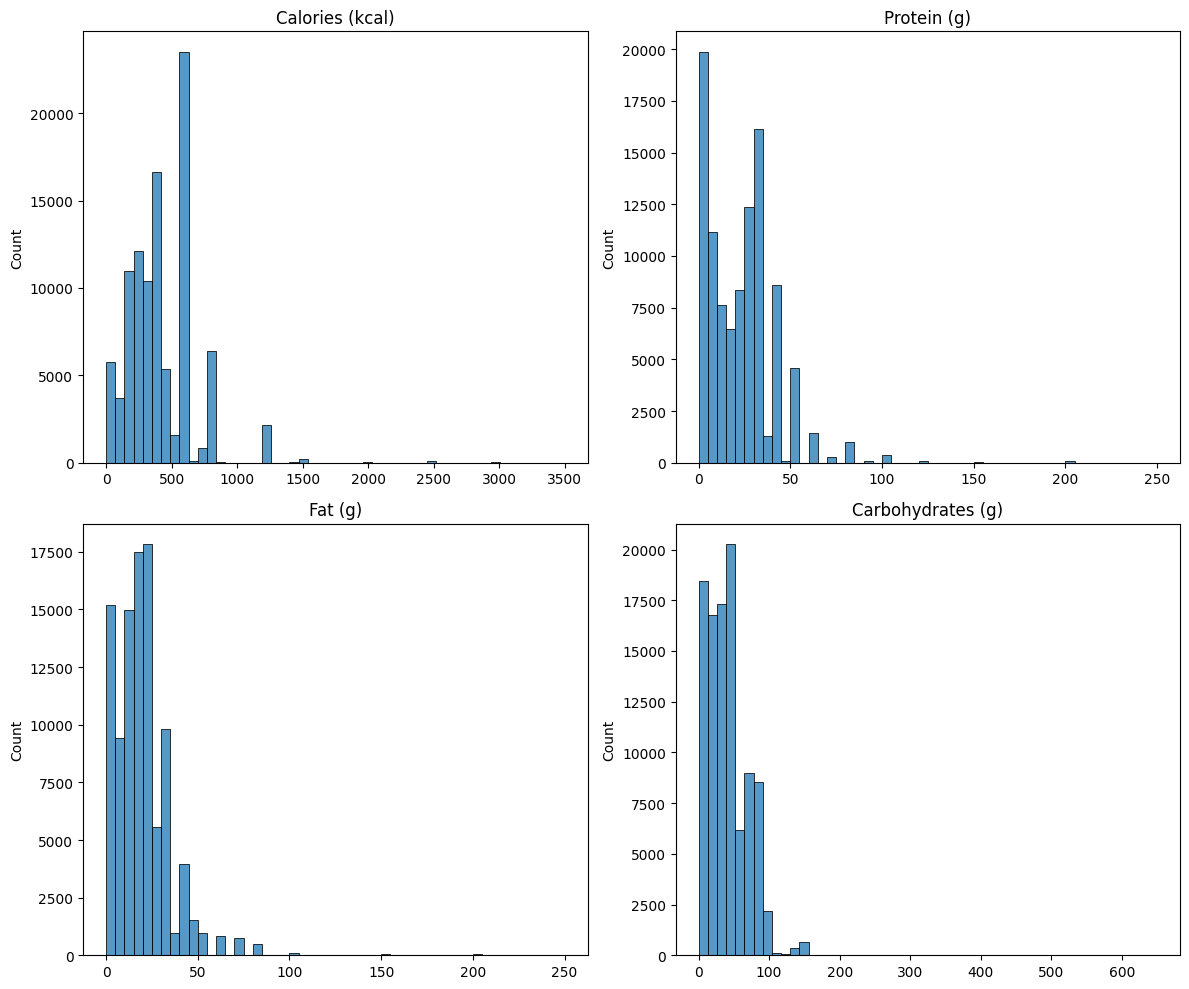

In [8]:
fig, ax = plt.subplots(2, 2, figsize = (12, 10))

# Flatten axes for indexing
ax = ax.flatten()

cols = ["calories_kcal", "protein_g", "fat_g", "carbohydrates_g"]
titles = ["Calories (kcal)", "Protein (g)", "Fat (g)", "Carbohydrates (g)"]

for i, col in enumerate(cols):
    sns.histplot(df[col], bins = 50, ax = ax[i], kde = False)
    ax[i].set_title(titles[i])
    ax[i].set_xlabel("")
    ax[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

The nutrition distributions are heavily right-skewed. We should consider removing the outliers as this could indicate samples that aren't single servings. 

### Look at macro/calorie relationship

<Axes: xlabel='calorie_error', ylabel='Count'>

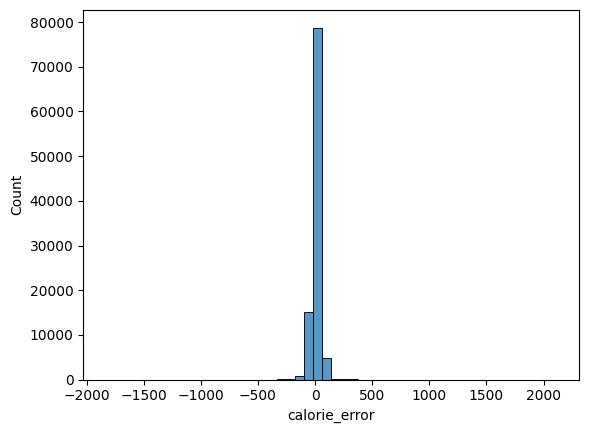

In [9]:
df["calorie_estimation"] = (4 * df["protein_g"] + 4 * df["carbohydrates_g"] + 9 * df["fat_g"])

df["calorie_error"] = df["calories_kcal"] - df["calorie_estimation"]

sns.histplot(df["calorie_error"], bins = 50)

Calorie estimations appear to be mostly on point with minimal error, slightly edging towards underestimation. This being said, there are outliers in the data. 

### Inspect dish label distribution

In [10]:
df["dish_name"].value_counts().head(20)

dish_name
Noodle Soup                           1960
Dumplings                             1236
Hot Pot                                995
Stir-fried Noodles                     796
Fried Chicken                          712
Apple                                  705
Watermelon                             695
Fried Rice                             612
Pizza                                  609
Beef Noodle Soup                       582
Lychee                                 566
Mixed Asian Cuisine                    530
Grilled Meat Skewers                   520
Seafood Platter                        420
Strawberries                           400
Braised Pork Belly                     399
Stir-fried Chicken with Vegetables     399
Beef Stir-Fry                          388
Braised Pork                           384
Vegetable Stir-Fry                     360
Name: count, dtype: int64

In [11]:
df["dish_name"].value_counts().tail(20)

dish_name
Quinoa Salad with Roasted Pumpkin       1
Vegetable Dumplings with Green Beans    1
Tofu Soup with Fried Bread              1
Vegetable and Peanut Stir-fry           1
Mung Bean Ice                           1
Steamed Eggplant with Garlic            1
Vegetable Stew with Fufu                1
Vegetable Tart and Frittata             1
Fried Tofu and Salad                    1
Chiles en Nogada                        1
Stir-fried Noodles with Tofu and Egg    1
Fried Fish Fillets                      1
Green Legume Soup                       1
Egg and Ham Tortilla Wraps              1
Pasta with Sauce and Protein            1
Savory Tofu with Egg                    1
Grass Jelly with Milk                   1
Fried Seaweed Snack                     1
Sausage and Egg Toast                   1
Bánh xèo                                1
Name: count, dtype: int64

Total Classes

In [12]:
classes = df["dish_name"].value_counts()
len(classes)

19288

Classes with 50 instances or more

In [13]:

majority_classes = classes[classes >= 50].index
len(majority_classes)

307

Check total rows of majority classes

In [54]:
df_majority = df[df["dish_name"].isin(majority_classes)]
df.shape[0], df_majority.shape[0]

(100000, 69409)

In total there are 19288 classes in the dataset, which is a significant number of classes. For the scope of this project, we will narrow down the number of classes.

### Inspect images

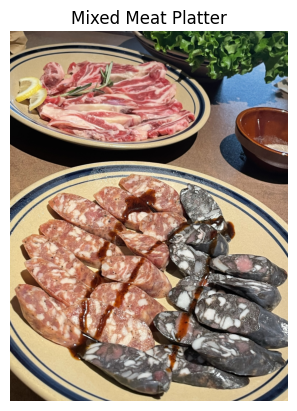

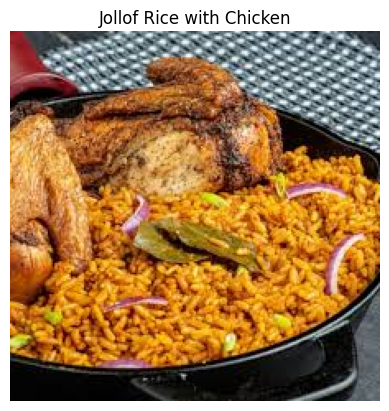

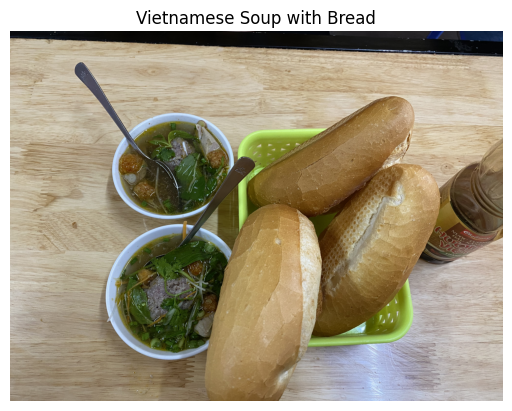

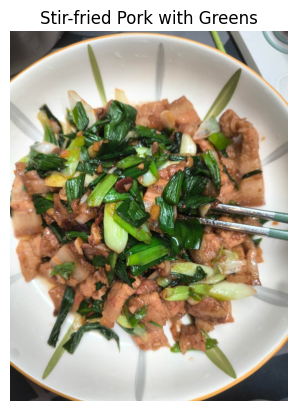

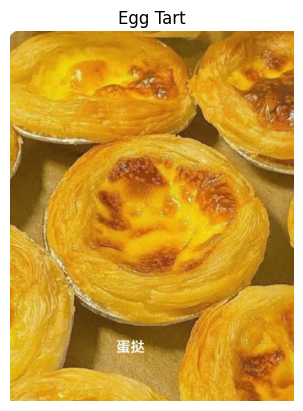

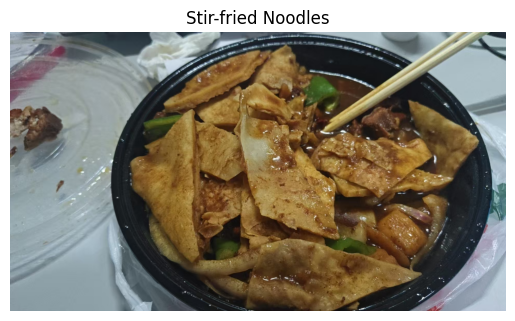

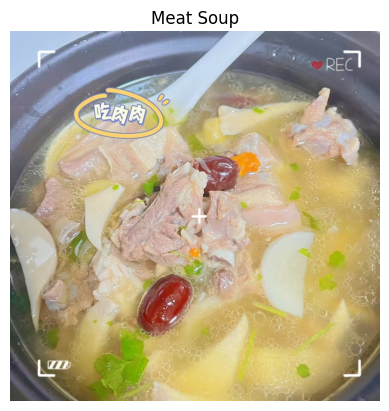

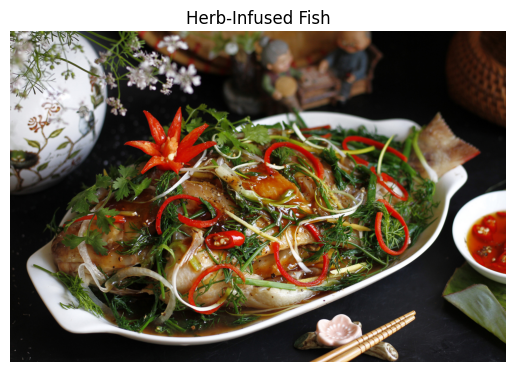

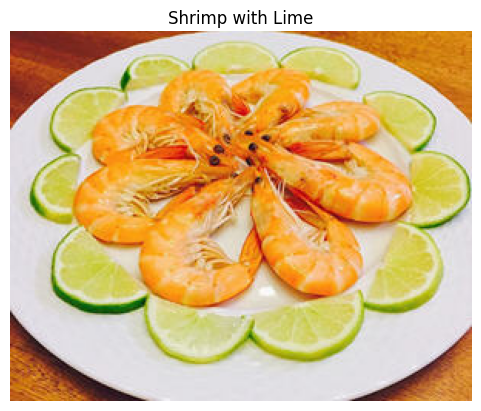

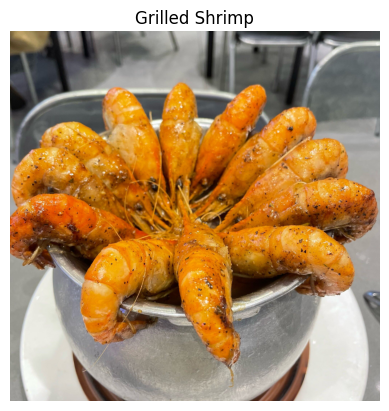

In [ ]:
sample = df.sample(10)

for _, row in sample.iterrows():
    url = row["image_url"]
    img = Image.open(BytesIO(requests.get(url).content))
    plt.imshow(img)
    plt.title(row["dish_name"])
    plt.axis("off")
    plt.show()


Images appear to be a mix of mostly single-serving plates and a few stock/bulk images. It would be difficult to remove the stock/bulk images without labeling each one so they will probably need to stay in the dataset. 

### Check for duplicates

In [ ]:
df["image_url"].duplicated().sum()

np.int64(0)

There are no duplicated image urls.